# 02 - Data Cleaning & CLAHE Enhancement

**Author:** Tan Ming Kai (24PMR12003)  
**Date:** 2025-11-10  
**Purpose:** Apply CLAHE enhancement and validate image quality

**Project:** Multi-Scale Vision Transformer (CrossViT) for COVID-19 Chest X-ray Classification  
**Academic Year:** 2025/26

---

## Objectives
1. ✅ Load image paths from CSV files created in notebook 01
2. ✅ Apply CLAHE enhancement (clipLimit=2.0, tileGridSize=(8,8))
3. ✅ Validate image quality and detect corrupted files
4. ✅ Resize images to 240×240 for CrossViT
5. ✅ Convert grayscale to RGB (3 channels)
6. ✅ Save preprocessed images to `data/processed/`
7. ✅ Generate before/after comparison visualizations

---

## CRISP-DM Phase: Data Preparation (Phase 2)

This notebook implements data cleaning and preprocessing as part of the CRISP-DM methodology.

## 1. Reproducibility Setup & Imports

**CRITICAL:** Load reproducibility seeds and required libraries.

In [1]:
"""
Data Cleaning Notebook for CrossViT COVID-19 FYP
Author: Tan Ming Kai (24PMR12003)
Purpose: Apply CLAHE enhancement and validate image quality
"""

# ============================================================================
# 1. REPRODUCIBILITY SETUP (ALWAYS FIRST!)
# ============================================================================
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("✅ Random seeds set to 42 for reproducibility")

# ============================================================================
# 2. STANDARD LIBRARY IMPORTS
# ============================================================================
import os
import sys
from pathlib import Path
import warnings
import shutil
warnings.filterwarnings('ignore')

# ============================================================================
# 3. DATA SCIENCE LIBRARIES
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# ============================================================================
# 4. COMPUTER VISION LIBRARIES
# ============================================================================
import cv2
from PIL import Image

print("\n✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"OpenCV version: {cv2.__version__}")

✅ Random seeds set to 42 for reproducibility



✅ All imports successful!
NumPy version: 2.2.6
Pandas version: 2.3.3
OpenCV version: 4.12.0


## 2. Configuration

Define paths and CLAHE parameters.

In [2]:
# Paths
CSV_DIR = Path("../data/processed")
OUTPUT_DIR = Path("../data/processed/clahe_enhanced")

# CLAHE parameters (DO NOT MODIFY - specified in CLAUDE.md)
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID_SIZE = (8, 8)

# Target image size for CrossViT
TARGET_SIZE = (240, 240)

# Create output directories
for split in ['train', 'val', 'test']:
    for class_name in ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']:
        output_path = OUTPUT_DIR / split / class_name
        output_path.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"\n📂 Input CSV Directory: {CSV_DIR.absolute()}")
print(f"📂 Output Directory: {OUTPUT_DIR.absolute()}")
print(f"\n🔧 CLAHE Parameters:")
print(f"   - Clip Limit: {CLAHE_CLIP_LIMIT}")
print(f"   - Tile Grid Size: {CLAHE_TILE_GRID_SIZE}")
print(f"\n📐 Target Image Size: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print(f"\n✅ Output directories created")
print("=" * 70)

CONFIGURATION

📂 Input CSV Directory: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed
📂 Output Directory: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed\clahe_enhanced

🔧 CLAHE Parameters:
   - Clip Limit: 2.0
   - Tile Grid Size: (8, 8)

📐 Target Image Size: 240×240

✅ Output directories created


## 3. Load CSV Files

Load the train, val, and test splits created in notebook 01.

In [3]:
print("=" * 70)
print("LOADING CSV FILES")
print("=" * 70)

# Load CSV files
train_df = pd.read_csv(CSV_DIR / "train.csv")
val_df = pd.read_csv(CSV_DIR / "val.csv")
test_df = pd.read_csv(CSV_DIR / "test.csv")

print(f"\n✅ CSV files loaded:")
print(f"   - Train: {len(train_df):,} images")
print(f"   - Val:   {len(val_df):,} images")
print(f"   - Test:  {len(test_df):,} images")
print(f"   - Total: {len(train_df) + len(val_df) + len(test_df):,} images")

print("\n📋 Sample from train set:")
print(train_df.head())

print("\n" + "=" * 70)

LOADING CSV FILES

✅ CSV files loaded:
   - Train: 16,931 images
   - Val:   2,117 images
   - Test:  2,117 images
   - Total: 21,165 images

📋 Sample from train set:
                                          image_path  label    class_name  \
0  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      2  Lung_Opacity   
1  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      1        Normal   
2  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      2  Lung_Opacity   
3  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      2  Lung_Opacity   
4  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...      1        Normal   

   split  
0  train  
1  train  
2  train  
3  train  
4  train  



## 4. Define CLAHE Enhancement Function

Create preprocessing function following EXACT specifications from CLAUDE.md.

In [4]:
def preprocess_image(image_path, clahe_clip=CLAHE_CLIP_LIMIT, tile_size=CLAHE_TILE_GRID_SIZE, target_size=TARGET_SIZE):
    """
    Apply CLAHE enhancement and preprocessing to chest X-ray image.
    
    Pipeline:
    1. Load image in grayscale
    2. Apply CLAHE enhancement
    3. Resize to target size (240×240)
    4. Convert grayscale to RGB (3 channels for CrossViT)
    
    Args:
        image_path (str): Path to input image
        clahe_clip (float): CLAHE clip limit (default: 2.0)
        tile_size (tuple): CLAHE tile grid size (default: (8, 8))
        target_size (tuple): Target image dimensions (default: (240, 240))
    
    Returns:
        tuple: (rgb_image, success_flag, error_message)
    """
    try:
        # 1. Load image in grayscale
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            return None, False, "Failed to load image"
        
        # 2. Apply CLAHE enhancement
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=tile_size)
        enhanced = clahe.apply(img)
        
        # 3. Resize to target size
        resized = cv2.resize(enhanced, target_size, interpolation=cv2.INTER_AREA)
        
        # 4. Convert grayscale to RGB (CrossViT requires 3 channels)
        rgb_image = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
        
        return rgb_image, True, None
        
    except Exception as e:
        return None, False, str(e)


print("✅ CLAHE preprocessing function defined")
print("\n📝 Pipeline Steps:")
print("   1. Load image in grayscale")
print(f"   2. Apply CLAHE (clip={CLAHE_CLIP_LIMIT}, tile={CLAHE_TILE_GRID_SIZE})")
print(f"   3. Resize to {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print("   4. Convert to RGB (3 channels)")

✅ CLAHE preprocessing function defined

📝 Pipeline Steps:
   1. Load image in grayscale
   2. Apply CLAHE (clip=2.0, tile=(8, 8))
   3. Resize to 240×240
   4. Convert to RGB (3 channels)


## 5. Test CLAHE Enhancement on Sample Images

Visualize before/after comparison for quality check.

TESTING CLAHE ENHANCEMENT


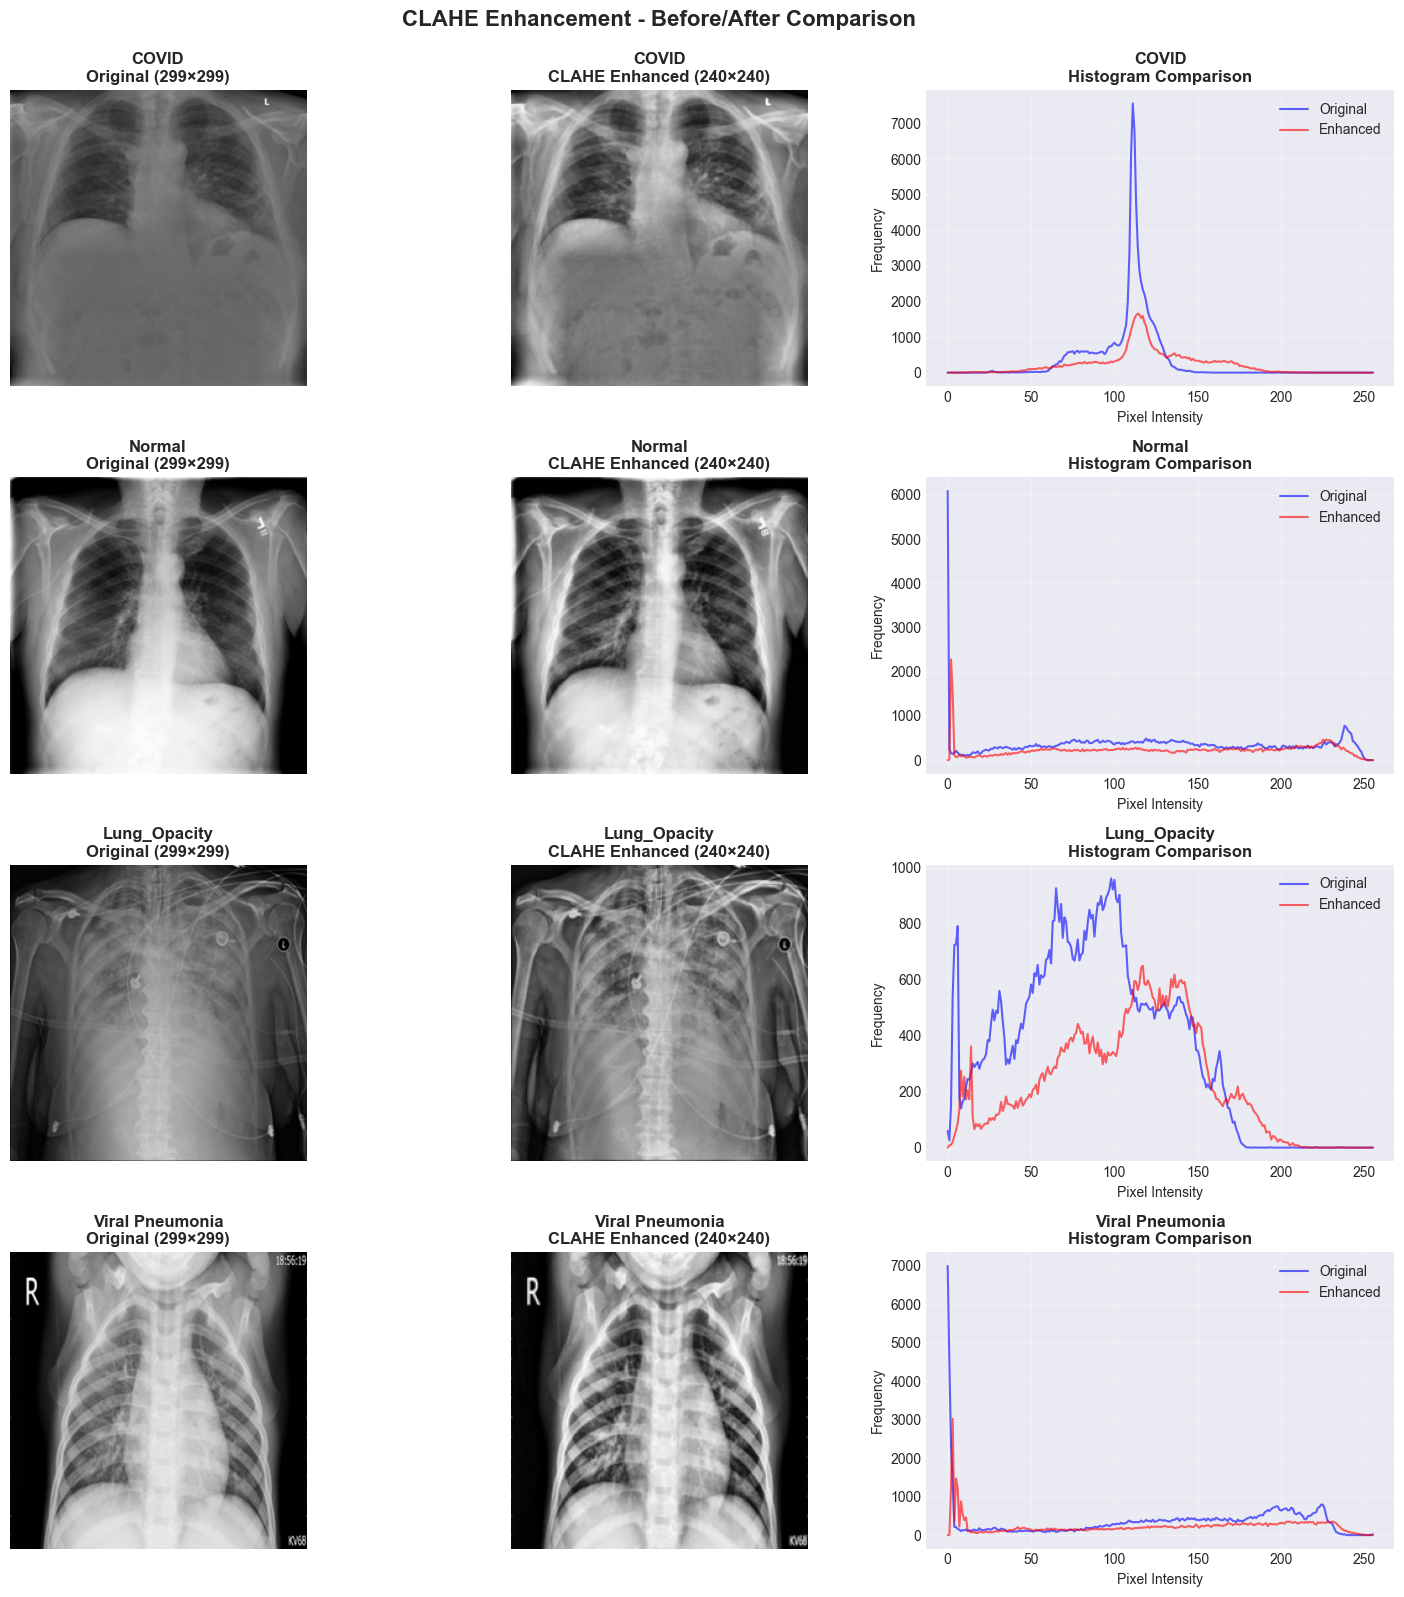


✅ CLAHE enhancement test complete

💡 Observations:
   - Enhanced images show improved contrast
   - Histogram equalization spreads pixel intensity distribution
   - Image size reduced from 299×299 to 240×240


In [5]:
print("=" * 70)
print("TESTING CLAHE ENHANCEMENT")
print("=" * 70)

# Sample one image from each class
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

for idx, class_name in enumerate(class_names):
    # Get one sample from this class
    sample = train_df[train_df['class_name'] == class_name].iloc[0]
    
    # Load original image
    original = cv2.imread(sample['image_path'], cv2.IMREAD_GRAYSCALE)
    
    # Apply CLAHE
    enhanced_rgb, success, error = preprocess_image(sample['image_path'])
    
    if success:
        # Convert RGB back to grayscale for visualization
        enhanced_gray = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2GRAY)
        
        # Calculate histogram
        hist_original = cv2.calcHist([original], [0], None, [256], [0, 256])
        hist_enhanced = cv2.calcHist([enhanced_gray], [0], None, [256], [0, 256])
        
        # Display original
        axes[idx, 0].imshow(original, cmap='gray')
        axes[idx, 0].set_title(f"{class_name}\nOriginal (299×299)", fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Display enhanced
        axes[idx, 1].imshow(enhanced_gray, cmap='gray')
        axes[idx, 1].set_title(f"{class_name}\nCLAHE Enhanced (240×240)", fontweight='bold')
        axes[idx, 1].axis('off')
        
        # Display histogram comparison
        axes[idx, 2].plot(hist_original, color='blue', alpha=0.6, label='Original')
        axes[idx, 2].plot(hist_enhanced, color='red', alpha=0.6, label='Enhanced')
        axes[idx, 2].set_title(f"{class_name}\nHistogram Comparison", fontweight='bold')
        axes[idx, 2].set_xlabel('Pixel Intensity')
        axes[idx, 2].set_ylabel('Frequency')
        axes[idx, 2].legend(loc='upper right')
        axes[idx, 2].grid(alpha=0.3)

plt.suptitle('CLAHE Enhancement - Before/After Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ CLAHE enhancement test complete")
print("\n💡 Observations:")
print("   - Enhanced images show improved contrast")
print("   - Histogram equalization spreads pixel intensity distribution")
print("   - Image size reduced from 299×299 to 240×240")
print("=" * 70)

## 6. Process Training Set

Apply CLAHE enhancement to all training images with progress tracking.

In [6]:
def process_dataset(df, split_name, output_base_dir):
    """
    Process entire dataset split with CLAHE enhancement.
    
    Args:
        df (pd.DataFrame): DataFrame with image paths and labels
        split_name (str): Name of split ('train', 'val', 'test')
        output_base_dir (Path): Base directory for output
    
    Returns:
        tuple: (processed_count, failed_count, failed_files)
    """
    print(f"\n{'='*70}")
    print(f"PROCESSING {split_name.upper()} SET")
    print(f"{'='*70}")
    
    processed_count = 0
    failed_count = 0
    failed_files = []
    
    # Process each image
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        # Get original image path
        original_path = Path(row['image_path'])
        
        # Create output path
        class_name = row['class_name']
        output_dir = output_base_dir / split_name / class_name
        output_path = output_dir / original_path.name
        
        # Apply CLAHE enhancement
        enhanced_img, success, error = preprocess_image(original_path)
        
        if success:
            # Save enhanced image
            # Convert RGB to BGR for cv2.imwrite
            enhanced_bgr = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(output_path), enhanced_bgr)
            processed_count += 1
        else:
            failed_count += 1
            failed_files.append({'path': str(original_path), 'error': error})
    
    # Print summary
    print(f"\n✅ {split_name.upper()} Processing Complete:")
    print(f"   - Processed: {processed_count:,} images")
    print(f"   - Failed:    {failed_count:,} images")
    print(f"   - Success Rate: {processed_count/(processed_count+failed_count)*100:.2f}%")
    
    return processed_count, failed_count, failed_files


# Process training set
train_processed, train_failed, train_failures = process_dataset(train_df, 'train', OUTPUT_DIR)

print("\n" + "=" * 70)


PROCESSING TRAIN SET


Processing train:   0%|          | 0/16931 [00:00<?, ?it/s]

Processing train:   0%|          | 32/16931 [00:00<00:52, 319.97it/s]

Processing train:   0%|          | 66/16931 [00:00<00:53, 318.03it/s]

Processing train:   1%|          | 98/16931 [00:00<00:53, 312.50it/s]

Processing train:   1%|          | 130/16931 [00:00<00:54, 309.59it/s]

Processing train:   1%|          | 166/16931 [00:00<00:54, 309.21it/s]

Processing train:   1%|          | 197/16931 [00:00<00:56, 295.05it/s]

Processing train:   1%|▏         | 227/16931 [00:00<00:57, 289.23it/s]

Processing train:   2%|▏         | 256/16931 [00:00<00:59, 279.14it/s]

Processing train:   2%|▏         | 286/16931 [00:00<00:58, 282.23it/s]

Processing train:   2%|▏         | 317/16931 [00:01<00:57, 289.44it/s]

Processing train:   2%|▏         | 351/16931 [00:01<00:56, 295.21it/s]

Processing train:   2%|▏         | 382/16931 [00:01<00:55, 298.36it/s]

Processing train:   2%|▏         | 413/16931 [00:01<00:55, 299.27it/s]

Processing train:   3%|▎         | 443/16931 [00:01<00:55, 299.32it/s]

Processing train:   3%|▎         | 473/16931 [00:01<00:54, 299.25it/s]

Processing train:   3%|▎         | 504/16931 [00:01<00:54, 299.96it/s]

Processing train:   3%|▎         | 535/16931 [00:01<00:54, 301.94it/s]

Processing train:   3%|▎         | 566/16931 [00:01<00:54, 300.26it/s]

Processing train:   4%|▎         | 597/16931 [00:01<00:54, 302.42it/s]

Processing train:   4%|▎         | 628/16931 [00:02<00:53, 302.74it/s]

Processing train:   4%|▍         | 659/16931 [00:02<00:53, 304.23it/s]

Processing train:   4%|▍         | 690/16931 [00:02<00:54, 296.43it/s]

Processing train:   4%|▍         | 722/16931 [00:02<00:53, 301.77it/s]

Processing train:   4%|▍         | 754/16931 [00:02<00:53, 303.80it/s]

Processing train:   5%|▍         | 787/16931 [00:02<00:53, 301.00it/s]

Processing train:   5%|▍         | 823/16931 [00:02<00:52, 305.34it/s]

Processing train:   5%|▌         | 856/16931 [00:02<00:52, 307.30it/s]

Processing train:   5%|▌         | 888/16931 [00:02<00:51, 309.90it/s]

Processing train:   5%|▌         | 920/16931 [00:03<00:51, 308.48it/s]

Processing train:   6%|▌         | 951/16931 [00:03<00:52, 302.69it/s]

Processing train:   6%|▌         | 982/16931 [00:03<00:52, 302.65it/s]

Processing train:   6%|▌         | 1013/16931 [00:03<00:52, 300.49it/s]

Processing train:   6%|▌         | 1046/16931 [00:03<00:52, 303.18it/s]

Processing train:   6%|▋         | 1077/16931 [00:03<00:52, 301.14it/s]

Processing train:   7%|▋         | 1108/16931 [00:03<00:52, 299.52it/s]

Processing train:   7%|▋         | 1139/16931 [00:03<00:52, 301.19it/s]

Processing train:   7%|▋         | 1172/16931 [00:03<00:51, 307.94it/s]

Processing train:   7%|▋         | 1203/16931 [00:03<00:51, 305.80it/s]

Processing train:   7%|▋         | 1235/16931 [00:04<00:51, 303.88it/s]

Processing train:   7%|▋         | 1268/16931 [00:04<00:51, 301.58it/s]

Processing train:   8%|▊         | 1299/16931 [00:04<00:52, 296.65it/s]

Processing train:   8%|▊         | 1330/16931 [00:04<00:52, 298.11it/s]

Processing train:   8%|▊         | 1360/16931 [00:04<00:52, 296.57it/s]

Processing train:   8%|▊         | 1392/16931 [00:04<00:51, 302.10it/s]

Processing train:   8%|▊         | 1426/16931 [00:04<00:51, 301.46it/s]

Processing train:   9%|▊         | 1463/16931 [00:04<00:49, 313.29it/s]

Processing train:   9%|▉         | 1496/16931 [00:04<00:48, 316.97it/s]

Processing train:   9%|▉         | 1530/16931 [00:05<00:47, 322.88it/s]

Processing train:   9%|▉         | 1563/16931 [00:05<00:48, 317.85it/s]

Processing train:   9%|▉         | 1595/16931 [00:05<00:49, 310.26it/s]

Processing train:  10%|▉         | 1632/16931 [00:05<00:47, 319.27it/s]

Processing train:  10%|▉         | 1664/16931 [00:05<00:49, 306.81it/s]

Processing train:  10%|█         | 1695/16931 [00:05<00:51, 298.74it/s]

Processing train:  10%|█         | 1726/16931 [00:05<00:50, 301.77it/s]

Processing train:  10%|█         | 1759/16931 [00:05<00:49, 308.92it/s]

Processing train:  11%|█         | 1791/16931 [00:05<00:48, 309.05it/s]

Processing train:  11%|█         | 1823/16931 [00:06<00:48, 309.59it/s]

Processing train:  11%|█         | 1855/16931 [00:06<00:48, 309.57it/s]

Processing train:  11%|█         | 1892/16931 [00:06<00:47, 315.43it/s]

Processing train:  11%|█▏        | 1925/16931 [00:06<00:47, 318.06it/s]

Processing train:  12%|█▏        | 1957/16931 [00:06<00:47, 317.03it/s]

Processing train:  12%|█▏        | 1989/16931 [00:06<00:47, 316.38it/s]

Processing train:  12%|█▏        | 2021/16931 [00:06<00:47, 310.95it/s]

Processing train:  12%|█▏        | 2053/16931 [00:06<00:49, 301.69it/s]

Processing train:  12%|█▏        | 2084/16931 [00:06<00:50, 293.70it/s]

Processing train:  12%|█▏        | 2114/16931 [00:06<00:51, 288.16it/s]

Processing train:  13%|█▎        | 2144/16931 [00:07<00:50, 291.08it/s]

Processing train:  13%|█▎        | 2174/16931 [00:07<00:52, 283.27it/s]

Processing train:  13%|█▎        | 2204/16931 [00:07<00:51, 286.22it/s]

Processing train:  13%|█▎        | 2238/16931 [00:07<00:49, 294.12it/s]

Processing train:  13%|█▎        | 2272/16931 [00:07<00:48, 303.06it/s]

Processing train:  14%|█▎        | 2303/16931 [00:07<00:49, 293.85it/s]

Processing train:  14%|█▍        | 2333/16931 [00:07<00:49, 293.89it/s]

Processing train:  14%|█▍        | 2363/16931 [00:07<00:49, 293.24it/s]

Processing train:  14%|█▍        | 2393/16931 [00:07<00:54, 267.87it/s]

Processing train:  14%|█▍        | 2424/16931 [00:08<00:52, 277.41it/s]

Processing train:  15%|█▍        | 2458/16931 [00:08<00:49, 291.03it/s]

Processing train:  15%|█▍        | 2488/16931 [00:08<00:51, 283.01it/s]

Processing train:  15%|█▍        | 2521/16931 [00:08<00:49, 292.65it/s]

Processing train:  15%|█▌        | 2553/16931 [00:08<00:47, 299.98it/s]

Processing train:  15%|█▌        | 2584/16931 [00:08<00:49, 287.59it/s]

Processing train:  15%|█▌        | 2615/16931 [00:08<00:48, 292.17it/s]

Processing train:  16%|█▌        | 2645/16931 [00:08<00:49, 290.46it/s]

Processing train:  16%|█▌        | 2677/16931 [00:08<00:48, 294.23it/s]

Processing train:  16%|█▌        | 2709/16931 [00:09<00:47, 300.94it/s]

Processing train:  16%|█▌        | 2742/16931 [00:09<00:46, 307.10it/s]

Processing train:  16%|█▋        | 2779/16931 [00:09<00:43, 322.04it/s]

Processing train:  17%|█▋        | 2813/16931 [00:09<00:43, 327.22it/s]

Processing train:  17%|█▋        | 2851/16931 [00:09<00:42, 333.58it/s]

Processing train:  17%|█▋        | 2885/16931 [00:09<00:43, 325.79it/s]

Processing train:  17%|█▋        | 2923/16931 [00:09<00:42, 331.87it/s]

Processing train:  17%|█▋        | 2960/16931 [00:09<00:41, 335.79it/s]

Processing train:  18%|█▊        | 2996/16931 [00:09<00:41, 333.01it/s]

Processing train:  18%|█▊        | 3031/16931 [00:09<00:42, 329.07it/s]

Processing train:  18%|█▊        | 3066/16931 [00:10<00:41, 332.19it/s]

Processing train:  18%|█▊        | 3101/16931 [00:10<00:41, 334.55it/s]

Processing train:  19%|█▊        | 3135/16931 [00:10<00:41, 329.81it/s]

Processing train:  19%|█▊        | 3169/16931 [00:10<00:42, 327.13it/s]

Processing train:  19%|█▉        | 3204/16931 [00:10<00:41, 331.25it/s]

Processing train:  19%|█▉        | 3238/16931 [00:10<00:41, 332.91it/s]

Processing train:  19%|█▉        | 3272/16931 [00:10<00:40, 334.98it/s]

Processing train:  20%|█▉        | 3306/16931 [00:10<00:41, 331.51it/s]

Processing train:  20%|█▉        | 3340/16931 [00:10<00:41, 326.88it/s]

Processing train:  20%|█▉        | 3373/16931 [00:11<00:41, 326.09it/s]

Processing train:  20%|██        | 3406/16931 [00:11<00:41, 322.80it/s]

Processing train:  20%|██        | 3439/16931 [00:11<00:42, 315.66it/s]

Processing train:  21%|██        | 3471/16931 [00:11<00:43, 311.71it/s]

Processing train:  21%|██        | 3503/16931 [00:11<00:43, 309.31it/s]

Processing train:  21%|██        | 3536/16931 [00:11<00:42, 312.44it/s]

Processing train:  21%|██        | 3571/16931 [00:11<00:42, 316.30it/s]

Processing train:  21%|██▏       | 3605/16931 [00:11<00:42, 316.33it/s]

Processing train:  21%|██▏       | 3640/16931 [00:11<00:42, 316.43it/s]

Processing train:  22%|██▏       | 3676/16931 [00:11<00:40, 326.43it/s]

Processing train:  22%|██▏       | 3709/16931 [00:12<00:40, 325.35it/s]

Processing train:  22%|██▏       | 3746/16931 [00:12<00:39, 330.33it/s]

Processing train:  22%|██▏       | 3781/16931 [00:12<00:39, 332.75it/s]

Processing train:  23%|██▎       | 3815/16931 [00:12<00:39, 330.49it/s]

Processing train:  23%|██▎       | 3849/16931 [00:12<00:40, 322.51it/s]

Processing train:  23%|██▎       | 3882/16931 [00:12<00:40, 322.66it/s]

Processing train:  23%|██▎       | 3918/16931 [00:12<00:40, 325.12it/s]

Processing train:  23%|██▎       | 3951/16931 [00:12<00:40, 323.11it/s]

Processing train:  24%|██▎       | 3988/16931 [00:12<00:39, 326.70it/s]

Processing train:  24%|██▍       | 4023/16931 [00:13<00:38, 330.98it/s]

Processing train:  24%|██▍       | 4057/16931 [00:13<00:39, 324.68it/s]

Processing train:  24%|██▍       | 4090/16931 [00:13<00:39, 324.48it/s]

Processing train:  24%|██▍       | 4123/16931 [00:13<00:40, 318.17it/s]

Processing train:  25%|██▍       | 4155/16931 [00:13<00:41, 310.80it/s]

Processing train:  25%|██▍       | 4187/16931 [00:13<00:41, 309.35it/s]

Processing train:  25%|██▍       | 4220/16931 [00:13<00:40, 314.89it/s]

Processing train:  25%|██▌       | 4253/16931 [00:13<00:40, 315.79it/s]

Processing train:  25%|██▌       | 4286/16931 [00:13<00:39, 317.62it/s]

Processing train:  26%|██▌       | 4323/16931 [00:13<00:38, 323.45it/s]

Processing train:  26%|██▌       | 4361/16931 [00:14<00:38, 330.66it/s]

Processing train:  26%|██▌       | 4395/16931 [00:14<00:38, 328.66it/s]

Processing train:  26%|██▌       | 4428/16931 [00:14<00:38, 326.45it/s]

Processing train:  26%|██▋       | 4461/16931 [00:14<00:38, 324.92it/s]

Processing train:  27%|██▋       | 4494/16931 [00:14<00:38, 325.74it/s]

Processing train:  27%|██▋       | 4529/16931 [00:14<00:37, 328.94it/s]

Processing train:  27%|██▋       | 4565/16931 [00:14<00:36, 336.07it/s]

Processing train:  27%|██▋       | 4599/16931 [00:14<00:36, 334.40it/s]

Processing train:  27%|██▋       | 4634/16931 [00:14<00:36, 333.18it/s]

Processing train:  28%|██▊       | 4668/16931 [00:15<00:39, 311.83it/s]

Processing train:  28%|██▊       | 4700/16931 [00:15<00:39, 306.16it/s]

Processing train:  28%|██▊       | 4731/16931 [00:15<00:41, 292.51it/s]

Processing train:  28%|██▊       | 4761/16931 [00:15<00:41, 290.33it/s]

Processing train:  28%|██▊       | 4792/16931 [00:15<00:41, 292.66it/s]

Processing train:  28%|██▊       | 4823/16931 [00:15<00:41, 294.92it/s]

Processing train:  29%|██▊       | 4853/16931 [00:15<00:40, 295.16it/s]

Processing train:  29%|██▉       | 4883/16931 [00:15<00:41, 292.59it/s]

Processing train:  29%|██▉       | 4918/16931 [00:15<00:40, 298.19it/s]

Processing train:  29%|██▉       | 4950/16931 [00:15<00:39, 301.36it/s]

Processing train:  29%|██▉       | 4982/16931 [00:16<00:39, 305.94it/s]

Processing train:  30%|██▉       | 5019/16931 [00:16<00:37, 314.18it/s]

Processing train:  30%|██▉       | 5051/16931 [00:16<00:38, 312.11it/s]

Processing train:  30%|███       | 5085/16931 [00:16<00:37, 318.91it/s]

Processing train:  30%|███       | 5118/16931 [00:16<00:37, 316.94it/s]

Processing train:  30%|███       | 5151/16931 [00:16<00:37, 317.44it/s]

Processing train:  31%|███       | 5183/16931 [00:16<00:37, 316.90it/s]

Processing train:  31%|███       | 5215/16931 [00:16<00:37, 312.39it/s]

Processing train:  31%|███       | 5247/16931 [00:16<00:37, 309.81it/s]

Processing train:  31%|███       | 5279/16931 [00:17<00:37, 310.22it/s]

Processing train:  31%|███▏      | 5313/16931 [00:17<00:36, 316.19it/s]

Processing train:  32%|███▏      | 5346/16931 [00:17<00:36, 318.57it/s]

Processing train:  32%|███▏      | 5379/16931 [00:17<00:36, 320.42it/s]

Processing train:  32%|███▏      | 5412/16931 [00:17<00:36, 314.61it/s]

Processing train:  32%|███▏      | 5444/16931 [00:17<00:37, 307.15it/s]

Processing train:  32%|███▏      | 5475/16931 [00:17<00:37, 305.06it/s]

Processing train:  33%|███▎      | 5507/16931 [00:17<00:37, 308.50it/s]

Processing train:  33%|███▎      | 5538/16931 [00:17<00:37, 306.67it/s]

Processing train:  33%|███▎      | 5570/16931 [00:17<00:36, 308.84it/s]

Processing train:  33%|███▎      | 5602/16931 [00:18<00:36, 311.54it/s]

Processing train:  33%|███▎      | 5634/16931 [00:18<00:36, 311.66it/s]

Processing train:  33%|███▎      | 5666/16931 [00:18<00:36, 305.17it/s]

Processing train:  34%|███▎      | 5698/16931 [00:18<00:36, 307.88it/s]

Processing train:  34%|███▍      | 5731/16931 [00:18<00:35, 311.95it/s]

Processing train:  34%|███▍      | 5763/16931 [00:18<00:36, 308.52it/s]

Processing train:  34%|███▍      | 5794/16931 [00:18<00:36, 303.98it/s]

Processing train:  34%|███▍      | 5827/16931 [00:18<00:36, 308.34it/s]

Processing train:  35%|███▍      | 5858/16931 [00:18<00:36, 305.91it/s]

Processing train:  35%|███▍      | 5889/16931 [00:19<00:36, 305.69it/s]

Processing train:  35%|███▍      | 5920/16931 [00:19<00:37, 292.11it/s]

Processing train:  35%|███▌      | 5952/16931 [00:19<00:36, 297.90it/s]

Processing train:  35%|███▌      | 5983/16931 [00:19<00:36, 299.05it/s]

Processing train:  36%|███▌      | 6014/16931 [00:19<00:36, 301.58it/s]

Processing train:  36%|███▌      | 6045/16931 [00:19<00:36, 297.49it/s]

Processing train:  36%|███▌      | 6077/16931 [00:19<00:35, 303.15it/s]

Processing train:  36%|███▌      | 6108/16931 [00:19<00:35, 303.55it/s]

Processing train:  36%|███▋      | 6139/16931 [00:19<00:35, 303.53it/s]

Processing train:  36%|███▋      | 6170/16931 [00:19<00:35, 303.75it/s]

Processing train:  37%|███▋      | 6201/16931 [00:20<00:35, 301.50it/s]

Processing train:  37%|███▋      | 6234/16931 [00:20<00:34, 308.57it/s]

Processing train:  37%|███▋      | 6267/16931 [00:20<00:34, 313.19it/s]

Processing train:  37%|███▋      | 6299/16931 [00:20<00:34, 311.74it/s]

Processing train:  37%|███▋      | 6331/16931 [00:20<00:34, 307.67it/s]

Processing train:  38%|███▊      | 6362/16931 [00:20<00:34, 305.62it/s]

Processing train:  38%|███▊      | 6393/16931 [00:20<00:35, 300.69it/s]

Processing train:  38%|███▊      | 6424/16931 [00:20<00:34, 301.81it/s]

Processing train:  38%|███▊      | 6455/16931 [00:20<00:34, 301.69it/s]

Processing train:  38%|███▊      | 6489/16931 [00:20<00:33, 308.11it/s]

Processing train:  39%|███▊      | 6523/16931 [00:21<00:33, 310.43it/s]

Processing train:  39%|███▊      | 6556/16931 [00:21<00:32, 314.65it/s]

Processing train:  39%|███▉      | 6588/16931 [00:21<00:33, 307.13it/s]

Processing train:  39%|███▉      | 6619/16931 [00:21<00:33, 305.94it/s]

Processing train:  39%|███▉      | 6651/16931 [00:21<00:33, 307.83it/s]

Processing train:  39%|███▉      | 6683/16931 [00:21<00:33, 309.67it/s]

Processing train:  40%|███▉      | 6717/16931 [00:21<00:32, 309.61it/s]

Processing train:  40%|███▉      | 6749/16931 [00:21<00:32, 311.16it/s]

Processing train:  40%|████      | 6785/16931 [00:21<00:32, 311.57it/s]

Processing train:  40%|████      | 6817/16931 [00:22<00:32, 310.50it/s]

Processing train:  40%|████      | 6850/16931 [00:22<00:31, 315.34it/s]

Processing train:  41%|████      | 6882/16931 [00:22<00:32, 313.48it/s]

Processing train:  41%|████      | 6914/16931 [00:22<00:32, 304.33it/s]

Processing train:  41%|████      | 6945/16931 [00:22<00:32, 304.56it/s]

Processing train:  41%|████      | 6977/16931 [00:22<00:32, 308.43it/s]

Processing train:  41%|████▏     | 7011/16931 [00:22<00:31, 315.72it/s]

Processing train:  42%|████▏     | 7043/16931 [00:22<00:31, 311.12it/s]

Processing train:  42%|████▏     | 7075/16931 [00:22<00:31, 313.46it/s]

Processing train:  42%|████▏     | 7110/16931 [00:22<00:30, 322.64it/s]

Processing train:  42%|████▏     | 7144/16931 [00:23<00:30, 325.91it/s]

Processing train:  42%|████▏     | 7179/16931 [00:23<00:29, 330.16it/s]

Processing train:  43%|████▎     | 7213/16931 [00:23<00:29, 329.08it/s]

Processing train:  43%|████▎     | 7246/16931 [00:23<00:29, 328.68it/s]

Processing train:  43%|████▎     | 7280/16931 [00:23<00:29, 331.42it/s]

Processing train:  43%|████▎     | 7314/16931 [00:23<00:29, 326.27it/s]

Processing train:  43%|████▎     | 7347/16931 [00:23<00:29, 323.05it/s]

Processing train:  44%|████▎     | 7380/16931 [00:23<00:29, 322.54it/s]

Processing train:  44%|████▍     | 7413/16931 [00:23<00:29, 322.86it/s]

Processing train:  44%|████▍     | 7446/16931 [00:24<00:29, 320.14it/s]

Processing train:  44%|████▍     | 7479/16931 [00:24<00:30, 311.09it/s]

Processing train:  44%|████▍     | 7511/16931 [00:24<00:30, 312.65it/s]

Processing train:  45%|████▍     | 7543/16931 [00:24<00:30, 307.58it/s]

Processing train:  45%|████▍     | 7574/16931 [00:24<00:31, 299.90it/s]

Processing train:  45%|████▍     | 7605/16931 [00:24<00:32, 282.79it/s]

Processing train:  45%|████▌     | 7634/16931 [00:24<00:33, 274.83it/s]

Processing train:  45%|████▌     | 7662/16931 [00:24<00:35, 258.03it/s]

Processing train:  45%|████▌     | 7692/16931 [00:24<00:34, 267.14it/s]

Processing train:  46%|████▌     | 7725/16931 [00:25<00:32, 282.70it/s]

Processing train:  46%|████▌     | 7754/16931 [00:25<00:32, 281.29it/s]

Processing train:  46%|████▌     | 7783/16931 [00:25<00:32, 283.13it/s]

Processing train:  46%|████▌     | 7816/16931 [00:25<00:30, 295.13it/s]

Processing train:  46%|████▋     | 7847/16931 [00:25<00:30, 298.48it/s]

Processing train:  47%|████▋     | 7881/16931 [00:25<00:29, 308.88it/s]

Processing train:  47%|████▋     | 7913/16931 [00:25<00:29, 309.50it/s]

Processing train:  47%|████▋     | 7945/16931 [00:25<00:28, 311.81it/s]

Processing train:  47%|████▋     | 7977/16931 [00:25<00:28, 312.97it/s]

Processing train:  47%|████▋     | 8010/16931 [00:25<00:28, 315.55it/s]

Processing train:  48%|████▊     | 8046/16931 [00:26<00:27, 328.08it/s]

Processing train:  48%|████▊     | 8079/16931 [00:26<00:28, 311.63it/s]

Processing train:  48%|████▊     | 8114/16931 [00:26<00:27, 322.13it/s]

Processing train:  48%|████▊     | 8147/16931 [00:26<00:27, 322.16it/s]

Processing train:  48%|████▊     | 8180/16931 [00:26<00:27, 320.15it/s]

Processing train:  49%|████▊     | 8213/16931 [00:26<00:27, 321.38it/s]

Processing train:  49%|████▊     | 8246/16931 [00:26<00:26, 322.92it/s]

Processing train:  49%|████▉     | 8279/16931 [00:26<00:26, 322.82it/s]

Processing train:  49%|████▉     | 8312/16931 [00:26<00:26, 322.13it/s]

Processing train:  49%|████▉     | 8346/16931 [00:26<00:26, 325.55it/s]

Processing train:  49%|████▉     | 8379/16931 [00:27<00:26, 326.20it/s]

Processing train:  50%|████▉     | 8413/16931 [00:27<00:25, 329.31it/s]

Processing train:  50%|████▉     | 8446/16931 [00:27<00:26, 322.22it/s]

Processing train:  50%|█████     | 8479/16931 [00:27<00:26, 320.66it/s]

Processing train:  50%|█████     | 8512/16931 [00:27<00:26, 321.44it/s]

Processing train:  50%|█████     | 8546/16931 [00:27<00:25, 325.67it/s]

Processing train:  51%|█████     | 8580/16931 [00:27<00:25, 326.19it/s]

Processing train:  51%|█████     | 8613/16931 [00:27<00:25, 323.40it/s]

Processing train:  51%|█████     | 8646/16931 [00:27<00:25, 321.70it/s]

Processing train:  51%|█████▏    | 8679/16931 [00:27<00:25, 321.65it/s]

Processing train:  51%|█████▏    | 8712/16931 [00:28<00:25, 318.42it/s]

Processing train:  52%|█████▏    | 8747/16931 [00:28<00:25, 327.11it/s]

Processing train:  52%|█████▏    | 8780/16931 [00:28<00:25, 325.25it/s]

Processing train:  52%|█████▏    | 8813/16931 [00:28<00:25, 317.38it/s]

Processing train:  52%|█████▏    | 8845/16931 [00:28<00:25, 315.35it/s]

Processing train:  52%|█████▏    | 8877/16931 [00:28<00:25, 314.88it/s]

Processing train:  53%|█████▎    | 8909/16931 [00:28<00:26, 308.17it/s]

Processing train:  53%|█████▎    | 8940/16931 [00:28<00:26, 298.58it/s]

Processing train:  53%|█████▎    | 8970/16931 [00:28<00:27, 293.74it/s]

Processing train:  53%|█████▎    | 9001/16931 [00:29<00:26, 296.17it/s]

Processing train:  53%|█████▎    | 9031/16931 [00:29<00:27, 291.85it/s]

Processing train:  54%|█████▎    | 9061/16931 [00:29<00:27, 289.26it/s]

Processing train:  54%|█████▎    | 9090/16931 [00:29<00:31, 250.33it/s]

Processing train:  54%|█████▍    | 9123/16931 [00:29<00:28, 269.89it/s]

Processing train:  54%|█████▍    | 9156/16931 [00:29<00:27, 286.06it/s]

Processing train:  54%|█████▍    | 9187/16931 [00:29<00:26, 291.14it/s]

Processing train:  54%|█████▍    | 9219/16931 [00:29<00:25, 296.79it/s]

Processing train:  55%|█████▍    | 9252/16931 [00:29<00:25, 305.09it/s]

Processing train:  55%|█████▍    | 9285/16931 [00:30<00:24, 311.65it/s]

Processing train:  55%|█████▌    | 9319/16931 [00:30<00:23, 318.90it/s]

Processing train:  55%|█████▌    | 9352/16931 [00:30<00:23, 320.43it/s]

Processing train:  55%|█████▌    | 9385/16931 [00:30<00:24, 302.81it/s]

Processing train:  56%|█████▌    | 9416/16931 [00:30<00:24, 302.07it/s]

Processing train:  56%|█████▌    | 9447/16931 [00:30<00:25, 298.33it/s]

Processing train:  56%|█████▌    | 9477/16931 [00:30<00:25, 296.33it/s]

Processing train:  56%|█████▌    | 9507/16931 [00:30<00:25, 294.19it/s]

Processing train:  56%|█████▋    | 9537/16931 [00:30<00:26, 280.24it/s]

Processing train:  57%|█████▋    | 9567/16931 [00:30<00:26, 283.14it/s]

Processing train:  57%|█████▋    | 9598/16931 [00:31<00:25, 290.25it/s]

Processing train:  57%|█████▋    | 9631/16931 [00:31<00:24, 301.26it/s]

Processing train:  57%|█████▋    | 9665/16931 [00:31<00:23, 309.94it/s]

Processing train:  57%|█████▋    | 9697/16931 [00:31<00:23, 308.91it/s]

Processing train:  57%|█████▋    | 9730/16931 [00:31<00:22, 313.21it/s]

Processing train:  58%|█████▊    | 9764/16931 [00:31<00:22, 319.47it/s]

Processing train:  58%|█████▊    | 9797/16931 [00:31<00:22, 321.09it/s]

Processing train:  58%|█████▊    | 9830/16931 [00:31<00:22, 318.67it/s]

Processing train:  58%|█████▊    | 9863/16931 [00:31<00:22, 319.61it/s]

Processing train:  58%|█████▊    | 9895/16931 [00:32<00:22, 315.41it/s]

Processing train:  59%|█████▊    | 9928/16931 [00:32<00:21, 319.65it/s]

Processing train:  59%|█████▉    | 9961/16931 [00:32<00:21, 320.99it/s]

Processing train:  59%|█████▉    | 9995/16931 [00:32<00:21, 323.92it/s]

Processing train:  59%|█████▉    | 10028/16931 [00:32<00:21, 319.22it/s]

Processing train:  59%|█████▉    | 10060/16931 [00:32<00:21, 318.35it/s]

Processing train:  60%|█████▉    | 10093/16931 [00:32<00:21, 321.12it/s]

Processing train:  60%|█████▉    | 10126/16931 [00:32<00:21, 320.32it/s]

Processing train:  60%|██████    | 10161/16931 [00:32<00:20, 325.10it/s]

Processing train:  60%|██████    | 10195/16931 [00:32<00:20, 329.37it/s]

Processing train:  60%|██████    | 10228/16931 [00:33<00:20, 327.33it/s]

Processing train:  61%|██████    | 10264/16931 [00:33<00:19, 334.05it/s]

Processing train:  61%|██████    | 10298/16931 [00:33<00:20, 327.05it/s]

Processing train:  61%|██████    | 10331/16931 [00:33<00:20, 325.83it/s]

Processing train:  61%|██████    | 10364/16931 [00:33<00:20, 323.72it/s]

Processing train:  61%|██████▏   | 10397/16931 [00:33<00:20, 321.26it/s]

Processing train:  62%|██████▏   | 10430/16931 [00:33<00:20, 320.80it/s]

Processing train:  62%|██████▏   | 10464/16931 [00:33<00:19, 324.33it/s]

Processing train:  62%|██████▏   | 10500/16931 [00:33<00:19, 323.19it/s]

Processing train:  62%|██████▏   | 10533/16931 [00:33<00:20, 317.50it/s]

Processing train:  62%|██████▏   | 10565/16931 [00:34<00:20, 315.54it/s]

Processing train:  63%|██████▎   | 10597/16931 [00:34<00:20, 316.31it/s]

Processing train:  63%|██████▎   | 10629/16931 [00:34<00:20, 303.86it/s]

Processing train:  63%|██████▎   | 10661/16931 [00:34<00:20, 306.99it/s]

Processing train:  63%|██████▎   | 10696/16931 [00:34<00:20, 310.89it/s]

Processing train:  63%|██████▎   | 10728/16931 [00:34<00:20, 309.29it/s]

Processing train:  64%|██████▎   | 10760/16931 [00:34<00:19, 310.07it/s]

Processing train:  64%|██████▎   | 10793/16931 [00:34<00:19, 311.24it/s]

Processing train:  64%|██████▍   | 10826/16931 [00:34<00:19, 313.59it/s]

Processing train:  64%|██████▍   | 10858/16931 [00:35<00:19, 314.67it/s]

Processing train:  64%|██████▍   | 10895/16931 [00:35<00:18, 321.97it/s]

Processing train:  65%|██████▍   | 10929/16931 [00:35<00:18, 323.83it/s]

Processing train:  65%|██████▍   | 10966/16931 [00:35<00:18, 323.09it/s]

Processing train:  65%|██████▍   | 10999/16931 [00:35<00:18, 317.74it/s]

Processing train:  65%|██████▌   | 11032/16931 [00:35<00:18, 318.65it/s]

Processing train:  65%|██████▌   | 11066/16931 [00:35<00:18, 323.74it/s]

Processing train:  66%|██████▌   | 11099/16931 [00:35<00:18, 323.33it/s]

Processing train:  66%|██████▌   | 11132/16931 [00:35<00:17, 323.70it/s]

Processing train:  66%|██████▌   | 11165/16931 [00:35<00:18, 317.30it/s]

Processing train:  66%|██████▌   | 11197/16931 [00:36<00:18, 313.20it/s]

Processing train:  66%|██████▋   | 11230/16931 [00:36<00:18, 316.68it/s]

Processing train:  67%|██████▋   | 11264/16931 [00:36<00:17, 323.21it/s]

Processing train:  67%|██████▋   | 11300/16931 [00:36<00:17, 320.14it/s]

Processing train:  67%|██████▋   | 11336/16931 [00:36<00:17, 323.71it/s]

Processing train:  67%|██████▋   | 11369/16931 [00:36<00:17, 320.96it/s]

Processing train:  67%|██████▋   | 11407/16931 [00:36<00:17, 324.16it/s]

Processing train:  68%|██████▊   | 11442/16931 [00:36<00:16, 325.65it/s]

Processing train:  68%|██████▊   | 11480/16931 [00:36<00:16, 329.79it/s]

Processing train:  68%|██████▊   | 11515/16931 [00:37<00:16, 331.46it/s]

Processing train:  68%|██████▊   | 11550/16931 [00:37<00:15, 336.69it/s]

Processing train:  68%|██████▊   | 11586/16931 [00:37<00:15, 334.69it/s]

Processing train:  69%|██████▊   | 11622/16931 [00:37<00:15, 334.62it/s]

Processing train:  69%|██████▉   | 11656/16931 [00:37<00:15, 330.65it/s]

Processing train:  69%|██████▉   | 11694/16931 [00:37<00:15, 332.64it/s]

Processing train:  69%|██████▉   | 11728/16931 [00:37<00:15, 327.29it/s]

Processing train:  69%|██████▉   | 11761/16931 [00:37<00:15, 326.16it/s]

Processing train:  70%|██████▉   | 11794/16931 [00:37<00:15, 325.60it/s]

Processing train:  70%|██████▉   | 11827/16931 [00:38<00:15, 321.33it/s]

Processing train:  70%|███████   | 11861/16931 [00:38<00:15, 324.49it/s]

Processing train:  70%|███████   | 11896/16931 [00:38<00:15, 327.17it/s]

Processing train:  70%|███████   | 11929/16931 [00:38<00:15, 315.78it/s]

Processing train:  71%|███████   | 11961/16931 [00:38<00:15, 314.81it/s]

Processing train:  71%|███████   | 11996/16931 [00:38<00:15, 322.96it/s]

Processing train:  71%|███████   | 12031/16931 [00:38<00:14, 326.84it/s]

Processing train:  71%|███████▏  | 12064/16931 [00:38<00:14, 325.47it/s]

Processing train:  71%|███████▏  | 12099/16931 [00:38<00:14, 328.71it/s]

Processing train:  72%|███████▏  | 12135/16931 [00:38<00:14, 330.77it/s]

Processing train:  72%|███████▏  | 12170/16931 [00:39<00:14, 331.63it/s]

Processing train:  72%|███████▏  | 12207/16931 [00:39<00:14, 333.79it/s]

Processing train:  72%|███████▏  | 12241/16931 [00:39<00:14, 332.76it/s]

Processing train:  73%|███████▎  | 12275/16931 [00:39<00:14, 326.73it/s]

Processing train:  73%|███████▎  | 12309/16931 [00:39<00:14, 325.45it/s]

Processing train:  73%|███████▎  | 12345/16931 [00:39<00:14, 326.59it/s]

Processing train:  73%|███████▎  | 12378/16931 [00:39<00:13, 325.59it/s]

Processing train:  73%|███████▎  | 12412/16931 [00:39<00:13, 327.61it/s]

Processing train:  74%|███████▎  | 12446/16931 [00:39<00:13, 329.28it/s]

Processing train:  74%|███████▎  | 12481/16931 [00:40<00:13, 321.05it/s]

Processing train:  74%|███████▍  | 12516/16931 [00:40<00:13, 325.04it/s]

Processing train:  74%|███████▍  | 12554/16931 [00:40<00:13, 327.68it/s]

Processing train:  74%|███████▍  | 12590/16931 [00:40<00:13, 328.94it/s]

Processing train:  75%|███████▍  | 12623/16931 [00:40<00:13, 324.45it/s]

Processing train:  75%|███████▍  | 12659/16931 [00:40<00:13, 320.48it/s]

Processing train:  75%|███████▍  | 12693/16931 [00:40<00:13, 324.44it/s]

Processing train:  75%|███████▌  | 12726/16931 [00:40<00:12, 325.45it/s]

Processing train:  75%|███████▌  | 12759/16931 [00:40<00:13, 317.74it/s]

Processing train:  76%|███████▌  | 12791/16931 [00:40<00:13, 310.86it/s]

Processing train:  76%|███████▌  | 12823/16931 [00:41<00:13, 313.42it/s]

Processing train:  76%|███████▌  | 12856/16931 [00:41<00:13, 313.21it/s]

Processing train:  76%|███████▌  | 12888/16931 [00:41<00:13, 310.89it/s]

Processing train:  76%|███████▋  | 12924/16931 [00:41<00:12, 315.01it/s]

Processing train:  77%|███████▋  | 12959/16931 [00:41<00:12, 314.20it/s]

Processing train:  77%|███████▋  | 12991/16931 [00:41<00:12, 309.13it/s]

Processing train:  77%|███████▋  | 13027/16931 [00:41<00:12, 314.29it/s]

Processing train:  77%|███████▋  | 13062/16931 [00:41<00:12, 322.20it/s]

Processing train:  77%|███████▋  | 13102/16931 [00:41<00:11, 329.39it/s]

Processing train:  78%|███████▊  | 13137/16931 [00:42<00:11, 334.92it/s]

Processing train:  78%|███████▊  | 13171/16931 [00:42<00:11, 334.38it/s]

Processing train:  78%|███████▊  | 13205/16931 [00:42<00:11, 334.37it/s]

Processing train:  78%|███████▊  | 13240/16931 [00:42<00:10, 336.71it/s]

Processing train:  78%|███████▊  | 13275/16931 [00:42<00:10, 339.39it/s]

Processing train:  79%|███████▊  | 13309/16931 [00:42<00:10, 336.35it/s]

Processing train:  79%|███████▉  | 13343/16931 [00:42<00:10, 331.94it/s]

Processing train:  79%|███████▉  | 13377/16931 [00:42<00:10, 330.52it/s]

Processing train:  79%|███████▉  | 13413/16931 [00:42<00:10, 338.38it/s]

Processing train:  79%|███████▉  | 13447/16931 [00:42<00:10, 331.51it/s]

Processing train:  80%|███████▉  | 13485/16931 [00:43<00:10, 334.65it/s]

Processing train:  80%|███████▉  | 13519/16931 [00:43<00:10, 330.55it/s]

Processing train:  80%|████████  | 13555/16931 [00:43<00:10, 324.99it/s]

Processing train:  80%|████████  | 13592/16931 [00:43<00:10, 330.82it/s]

Processing train:  80%|████████  | 13626/16931 [00:43<00:09, 330.67it/s]

Processing train:  81%|████████  | 13661/16931 [00:43<00:09, 333.79it/s]

Processing train:  81%|████████  | 13696/16931 [00:43<00:09, 336.74it/s]

Processing train:  81%|████████  | 13730/16931 [00:43<00:09, 336.26it/s]

Processing train:  81%|████████▏ | 13765/16931 [00:43<00:09, 333.59it/s]

Processing train:  82%|████████▏ | 13799/16931 [00:44<00:09, 330.62it/s]

Processing train:  82%|████████▏ | 13835/16931 [00:44<00:09, 327.37it/s]

Processing train:  82%|████████▏ | 13869/16931 [00:44<00:09, 329.27it/s]

Processing train:  82%|████████▏ | 13903/16931 [00:44<00:09, 330.19it/s]

Processing train:  82%|████████▏ | 13938/16931 [00:44<00:08, 334.06it/s]

Processing train:  83%|████████▎ | 13975/16931 [00:44<00:08, 343.19it/s]

Processing train:  83%|████████▎ | 14010/16931 [00:44<00:08, 343.28it/s]

Processing train:  83%|████████▎ | 14045/16931 [00:44<00:08, 335.42it/s]

Processing train:  83%|████████▎ | 14079/16931 [00:44<00:08, 332.08it/s]

Processing train:  83%|████████▎ | 14113/16931 [00:44<00:08, 332.89it/s]

Processing train:  84%|████████▎ | 14147/16931 [00:45<00:09, 307.56it/s]

Processing train:  84%|████████▎ | 14179/16931 [00:45<00:08, 309.68it/s]

Processing train:  84%|████████▍ | 14211/16931 [00:45<00:08, 311.73it/s]

Processing train:  84%|████████▍ | 14243/16931 [00:45<00:11, 240.08it/s]

Processing train:  84%|████████▍ | 14274/16931 [00:45<00:10, 253.82it/s]

Processing train:  85%|████████▍ | 14308/16931 [00:45<00:09, 269.35it/s]

Processing train:  85%|████████▍ | 14339/16931 [00:45<00:09, 278.38it/s]

Processing train:  85%|████████▍ | 14374/16931 [00:45<00:08, 289.96it/s]

Processing train:  85%|████████▌ | 14406/16931 [00:46<00:08, 296.85it/s]

Processing train:  85%|████████▌ | 14437/16931 [00:46<00:08, 299.46it/s]

Processing train:  85%|████████▌ | 14470/16931 [00:46<00:08, 306.36it/s]

Processing train:  86%|████████▌ | 14504/16931 [00:46<00:07, 311.77it/s]

Processing train:  86%|████████▌ | 14536/16931 [00:46<00:07, 312.88it/s]

Processing train:  86%|████████▌ | 14568/16931 [00:46<00:07, 309.49it/s]

Processing train:  86%|████████▌ | 14601/16931 [00:46<00:07, 315.39it/s]

Processing train:  86%|████████▋ | 14636/16931 [00:46<00:07, 324.58it/s]

Processing train:  87%|████████▋ | 14669/16931 [00:46<00:07, 317.42it/s]

Processing train:  87%|████████▋ | 14704/16931 [00:46<00:06, 325.41it/s]

Processing train:  87%|████████▋ | 14737/16931 [00:47<00:06, 320.30it/s]

Processing train:  87%|████████▋ | 14770/16931 [00:47<00:07, 270.82it/s]

Processing train:  87%|████████▋ | 14804/16931 [00:47<00:07, 287.80it/s]

Processing train:  88%|████████▊ | 14837/16931 [00:47<00:07, 298.79it/s]

Processing train:  88%|████████▊ | 14868/16931 [00:47<00:07, 289.27it/s]

Processing train:  88%|████████▊ | 14904/16931 [00:47<00:06, 307.12it/s]

Processing train:  88%|████████▊ | 14936/16931 [00:47<00:06, 298.35it/s]

Processing train:  88%|████████▊ | 14968/16931 [00:47<00:06, 301.47it/s]

Processing train:  89%|████████▊ | 15000/16931 [00:47<00:06, 303.67it/s]

Processing train:  89%|████████▉ | 15031/16931 [00:48<00:06, 302.48it/s]

Processing train:  89%|████████▉ | 15062/16931 [00:48<00:06, 302.54it/s]

Processing train:  89%|████████▉ | 15094/16931 [00:48<00:05, 306.51it/s]

Processing train:  89%|████████▉ | 15126/16931 [00:48<00:05, 303.58it/s]

Processing train:  90%|████████▉ | 15157/16931 [00:48<00:06, 286.56it/s]

Processing train:  90%|████████▉ | 15189/16931 [00:48<00:05, 294.67it/s]

Processing train:  90%|████████▉ | 15222/16931 [00:48<00:05, 301.47it/s]

Processing train:  90%|█████████ | 15253/16931 [00:48<00:05, 302.92it/s]

Processing train:  90%|█████████ | 15285/16931 [00:48<00:05, 306.62it/s]

Processing train:  90%|█████████ | 15317/16931 [00:49<00:05, 303.71it/s]

Processing train:  91%|█████████ | 15353/16931 [00:49<00:05, 314.45it/s]

Processing train:  91%|█████████ | 15385/16931 [00:49<00:04, 314.95it/s]

Processing train:  91%|█████████ | 15417/16931 [00:49<00:04, 312.07it/s]

Processing train:  91%|█████████ | 15449/16931 [00:49<00:04, 306.15it/s]

Processing train:  91%|█████████▏| 15480/16931 [00:49<00:04, 296.64it/s]

Processing train:  92%|█████████▏| 15513/16931 [00:49<00:04, 303.97it/s]

Processing train:  92%|█████████▏| 15544/16931 [00:49<00:04, 295.71it/s]

Processing train:  92%|█████████▏| 15576/16931 [00:49<00:04, 301.52it/s]

Processing train:  92%|█████████▏| 15607/16931 [00:49<00:04, 303.96it/s]

Processing train:  92%|█████████▏| 15638/16931 [00:50<00:04, 303.36it/s]

Processing train:  93%|█████████▎| 15670/16931 [00:50<00:04, 308.18it/s]

Processing train:  93%|█████████▎| 15702/16931 [00:50<00:03, 310.35it/s]

Processing train:  93%|█████████▎| 15734/16931 [00:50<00:03, 307.37it/s]

Processing train:  93%|█████████▎| 15768/16931 [00:50<00:03, 312.74it/s]

Processing train:  93%|█████████▎| 15800/16931 [00:50<00:03, 298.78it/s]

Processing train:  94%|█████████▎| 15831/16931 [00:50<00:03, 295.37it/s]

Processing train:  94%|█████████▎| 15862/16931 [00:50<00:03, 297.01it/s]

Processing train:  94%|█████████▍| 15892/16931 [00:50<00:03, 269.33it/s]

Processing train:  94%|█████████▍| 15920/16931 [00:51<00:03, 266.82it/s]

Processing train:  94%|█████████▍| 15948/16931 [00:51<00:03, 246.27it/s]

Processing train:  94%|█████████▍| 15980/16931 [00:51<00:03, 261.17it/s]

Processing train:  95%|█████████▍| 16014/16931 [00:51<00:03, 279.45it/s]

Processing train:  95%|█████████▍| 16048/16931 [00:51<00:03, 293.74it/s]

Processing train:  95%|█████████▌| 16089/16931 [00:51<00:02, 312.73it/s]

Processing train:  95%|█████████▌| 16124/16931 [00:51<00:02, 322.05it/s]

Processing train:  95%|█████████▌| 16163/16931 [00:51<00:02, 330.23it/s]

Processing train:  96%|█████████▌| 16197/16931 [00:51<00:02, 330.48it/s]

Processing train:  96%|█████████▌| 16233/16931 [00:52<00:02, 336.08it/s]

Processing train:  96%|█████████▌| 16268/16931 [00:52<00:01, 338.41it/s]

Processing train:  96%|█████████▋| 16302/16931 [00:52<00:01, 333.94it/s]

Processing train:  96%|█████████▋| 16336/16931 [00:52<00:01, 321.13it/s]

Processing train:  97%|█████████▋| 16369/16931 [00:52<00:01, 322.82it/s]

Processing train:  97%|█████████▋| 16402/16931 [00:52<00:01, 320.63it/s]

Processing train:  97%|█████████▋| 16435/16931 [00:52<00:01, 318.80it/s]

Processing train:  97%|█████████▋| 16467/16931 [00:52<00:01, 294.13it/s]

Processing train:  97%|█████████▋| 16501/16931 [00:52<00:01, 306.33it/s]

Processing train:  98%|█████████▊| 16534/16931 [00:53<00:01, 310.32it/s]

Processing train:  98%|█████████▊| 16567/16931 [00:53<00:01, 314.15it/s]

Processing train:  98%|█████████▊| 16602/16931 [00:53<00:01, 319.96it/s]

Processing train:  98%|█████████▊| 16637/16931 [00:53<00:00, 322.62it/s]

Processing train:  98%|█████████▊| 16673/16931 [00:53<00:00, 325.46it/s]

Processing train:  99%|█████████▊| 16706/16931 [00:53<00:00, 320.34it/s]

Processing train:  99%|█████████▉| 16739/16931 [00:53<00:00, 315.61it/s]

Processing train:  99%|█████████▉| 16772/16931 [00:53<00:00, 316.44it/s]

Processing train:  99%|█████████▉| 16804/16931 [00:53<00:00, 315.68it/s]

Processing train:  99%|█████████▉| 16840/16931 [00:53<00:00, 316.88it/s]

Processing train: 100%|█████████▉| 16873/16931 [00:54<00:00, 318.12it/s]

Processing train: 100%|█████████▉| 16911/16931 [00:54<00:00, 322.73it/s]

Processing train: 100%|██████████| 16931/16931 [00:54<00:00, 311.96it/s]


✅ TRAIN Processing Complete:
   - Processed: 16,931 images
   - Failed:    0 images
   - Success Rate: 100.00%



## 7. Process Validation Set

Apply CLAHE enhancement to all validation images.

In [7]:
# Process validation set
val_processed, val_failed, val_failures = process_dataset(val_df, 'val', OUTPUT_DIR)

print("\n" + "=" * 70)


PROCESSING VAL SET


Processing val:   0%|          | 0/2117 [00:00<?, ?it/s]

Processing val:   2%|▏         | 33/2117 [00:00<00:06, 327.76it/s]

Processing val:   3%|▎         | 67/2117 [00:00<00:06, 332.23it/s]

Processing val:   5%|▍         | 101/2117 [00:00<00:06, 333.74it/s]

Processing val:   6%|▋         | 135/2117 [00:00<00:06, 330.17it/s]

Processing val:   8%|▊         | 170/2117 [00:00<00:05, 337.12it/s]

Processing val:  10%|▉         | 204/2117 [00:00<00:05, 330.78it/s]

Processing val:  11%|█         | 238/2117 [00:00<00:05, 328.40it/s]

Processing val:  13%|█▎        | 273/2117 [00:00<00:05, 333.23it/s]

Processing val:  15%|█▍        | 308/2117 [00:00<00:05, 335.38it/s]

Processing val:  16%|█▌        | 342/2117 [00:01<00:05, 332.79it/s]

Processing val:  18%|█▊        | 376/2117 [00:01<00:05, 334.54it/s]

Processing val:  19%|█▉        | 411/2117 [00:01<00:05, 337.90it/s]

Processing val:  21%|██        | 445/2117 [00:01<00:04, 336.46it/s]

Processing val:  23%|██▎       | 479/2117 [00:01<00:04, 327.96it/s]

Processing val:  24%|██▍       | 513/2117 [00:01<00:04, 329.64it/s]

Processing val:  26%|██▌       | 547/2117 [00:01<00:04, 331.87it/s]

Processing val:  28%|██▊       | 584/2117 [00:01<00:04, 340.70it/s]

Processing val:  29%|██▉       | 619/2117 [00:01<00:04, 333.21it/s]

Processing val:  31%|███       | 654/2117 [00:01<00:04, 336.36it/s]

Processing val:  32%|███▏      | 688/2117 [00:02<00:04, 330.82it/s]

Processing val:  34%|███▍      | 723/2117 [00:02<00:04, 333.85it/s]

Processing val:  36%|███▌      | 758/2117 [00:02<00:04, 335.35it/s]

Processing val:  37%|███▋      | 793/2117 [00:02<00:03, 338.30it/s]

Processing val:  39%|███▉      | 827/2117 [00:02<00:03, 336.37it/s]

Processing val:  41%|████      | 862/2117 [00:02<00:03, 330.95it/s]

Processing val:  42%|████▏     | 897/2117 [00:02<00:03, 335.02it/s]

Processing val:  44%|████▍     | 932/2117 [00:02<00:03, 332.31it/s]

Processing val:  46%|████▌     | 966/2117 [00:02<00:03, 328.51it/s]

Processing val:  47%|████▋     | 999/2117 [00:03<00:03, 327.02it/s]

Processing val:  49%|████▉     | 1033/2117 [00:03<00:03, 330.59it/s]

Processing val:  50%|█████     | 1069/2117 [00:03<00:03, 336.85it/s]

Processing val:  52%|█████▏    | 1103/2117 [00:03<00:03, 332.40it/s]

Processing val:  54%|█████▎    | 1137/2117 [00:03<00:02, 332.32it/s]

Processing val:  55%|█████▌    | 1171/2117 [00:03<00:02, 327.07it/s]

Processing val:  57%|█████▋    | 1205/2117 [00:03<00:02, 327.86it/s]

Processing val:  58%|█████▊    | 1238/2117 [00:03<00:02, 323.78it/s]

Processing val:  60%|██████    | 1271/2117 [00:03<00:02, 325.57it/s]

Processing val:  62%|██████▏   | 1304/2117 [00:03<00:02, 326.60it/s]

Processing val:  63%|██████▎   | 1337/2117 [00:04<00:02, 312.07it/s]

Processing val:  65%|██████▍   | 1369/2117 [00:04<00:02, 308.63it/s]

Processing val:  66%|██████▌   | 1400/2117 [00:04<00:02, 299.90it/s]

Processing val:  68%|██████▊   | 1434/2117 [00:04<00:02, 308.85it/s]

Processing val:  69%|██████▉   | 1465/2117 [00:04<00:02, 302.54it/s]

Processing val:  71%|███████   | 1498/2117 [00:04<00:02, 309.39it/s]

Processing val:  72%|███████▏  | 1534/2117 [00:04<00:01, 320.90it/s]

Processing val:  74%|███████▍  | 1569/2117 [00:04<00:01, 327.44it/s]

Processing val:  76%|███████▌  | 1602/2117 [00:04<00:01, 326.33it/s]

Processing val:  77%|███████▋  | 1640/2117 [00:04<00:01, 334.92it/s]

Processing val:  79%|███████▉  | 1674/2117 [00:05<00:01, 329.15it/s]

Processing val:  81%|████████  | 1708/2117 [00:05<00:01, 332.23it/s]

Processing val:  82%|████████▏ | 1742/2117 [00:05<00:01, 320.40it/s]

Processing val:  84%|████████▍ | 1776/2117 [00:05<00:01, 325.31it/s]

Processing val:  86%|████████▌ | 1811/2117 [00:05<00:00, 331.85it/s]

Processing val:  87%|████████▋ | 1846/2117 [00:05<00:00, 335.18it/s]

Processing val:  89%|████████▉ | 1880/2117 [00:05<00:00, 334.43it/s]

Processing val:  91%|█████████ | 1917/2117 [00:05<00:00, 337.40it/s]

Processing val:  92%|█████████▏| 1951/2117 [00:05<00:00, 333.25it/s]

Processing val:  94%|█████████▍| 1985/2117 [00:06<00:00, 334.78it/s]

Processing val:  95%|█████████▌| 2020/2117 [00:06<00:00, 337.28it/s]

Processing val:  97%|█████████▋| 2055/2117 [00:06<00:00, 340.44it/s]

Processing val:  99%|█████████▊| 2090/2117 [00:06<00:00, 340.58it/s]

Processing val: 100%|██████████| 2117/2117 [00:06<00:00, 329.92it/s]


✅ VAL Processing Complete:
   - Processed: 2,117 images
   - Failed:    0 images
   - Success Rate: 100.00%



## 8. Process Test Set

Apply CLAHE enhancement to all test images.

In [8]:
# Process test set
test_processed, test_failed, test_failures = process_dataset(test_df, 'test', OUTPUT_DIR)

print("\n" + "=" * 70)


PROCESSING TEST SET


Processing test:   0%|          | 0/2117 [00:00<?, ?it/s]

Processing test:   1%|▏         | 31/2117 [00:00<00:06, 307.89it/s]

Processing test:   3%|▎         | 65/2117 [00:00<00:06, 326.36it/s]

Processing test:   5%|▍         | 99/2117 [00:00<00:06, 329.12it/s]

Processing test:   6%|▋         | 134/2117 [00:00<00:05, 332.23it/s]

Processing test:   8%|▊         | 169/2117 [00:00<00:05, 334.74it/s]

Processing test:  10%|▉         | 203/2117 [00:00<00:05, 331.79it/s]

Processing test:  11%|█         | 237/2117 [00:00<00:05, 329.32it/s]

Processing test:  13%|█▎        | 271/2117 [00:00<00:05, 331.47it/s]

Processing test:  15%|█▍        | 307/2117 [00:00<00:05, 336.31it/s]

Processing test:  16%|█▌        | 342/2117 [00:01<00:05, 333.87it/s]

Processing test:  18%|█▊        | 376/2117 [00:01<00:05, 326.32it/s]

Processing test:  19%|█▉        | 409/2117 [00:01<00:05, 326.13it/s]

Processing test:  21%|██        | 442/2117 [00:01<00:05, 326.30it/s]

Processing test:  22%|██▏       | 476/2117 [00:01<00:04, 329.57it/s]

Processing test:  24%|██▍       | 513/2117 [00:01<00:04, 337.93it/s]

Processing test:  26%|██▌       | 547/2117 [00:01<00:04, 333.28it/s]

Processing test:  27%|██▋       | 582/2117 [00:01<00:04, 337.61it/s]

Processing test:  29%|██▉       | 616/2117 [00:01<00:04, 332.41it/s]

Processing test:  31%|███       | 652/2117 [00:01<00:04, 337.78it/s]

Processing test:  32%|███▏      | 687/2117 [00:02<00:04, 340.55it/s]

Processing test:  34%|███▍      | 722/2117 [00:02<00:04, 334.63it/s]

Processing test:  36%|███▌      | 759/2117 [00:02<00:03, 342.84it/s]

Processing test:  38%|███▊      | 794/2117 [00:02<00:03, 335.96it/s]

Processing test:  39%|███▉      | 828/2117 [00:02<00:03, 336.26it/s]

Processing test:  41%|████      | 863/2117 [00:02<00:03, 339.68it/s]

Processing test:  42%|████▏     | 898/2117 [00:02<00:03, 341.98it/s]

Processing test:  44%|████▍     | 933/2117 [00:02<00:03, 343.14it/s]

Processing test:  46%|████▌     | 972/2117 [00:02<00:03, 350.21it/s]

Processing test:  48%|████▊     | 1013/2117 [00:03<00:03, 359.95it/s]

Processing test:  50%|████▉     | 1052/2117 [00:03<00:02, 366.25it/s]

Processing test:  51%|█████▏    | 1089/2117 [00:03<00:02, 358.03it/s]

Processing test:  53%|█████▎    | 1130/2117 [00:03<00:02, 371.46it/s]

Processing test:  55%|█████▌    | 1172/2117 [00:03<00:02, 376.98it/s]

Processing test:  57%|█████▋    | 1211/2117 [00:03<00:02, 377.28it/s]

Processing test:  59%|█████▉    | 1249/2117 [00:03<00:02, 376.82it/s]

Processing test:  61%|██████    | 1287/2117 [00:03<00:02, 365.82it/s]

Processing test:  63%|██████▎   | 1325/2117 [00:03<00:02, 369.46it/s]

Processing test:  64%|██████▍   | 1363/2117 [00:03<00:02, 371.76it/s]

Processing test:  66%|██████▌   | 1401/2117 [00:04<00:01, 369.50it/s]

Processing test:  68%|██████▊   | 1441/2117 [00:04<00:01, 376.60it/s]

Processing test:  70%|██████▉   | 1479/2117 [00:04<00:01, 374.89it/s]

Processing test:  72%|███████▏  | 1518/2117 [00:04<00:01, 375.90it/s]

Processing test:  74%|███████▎  | 1556/2117 [00:04<00:01, 372.90it/s]

Processing test:  75%|███████▌  | 1594/2117 [00:04<00:01, 364.62it/s]

Processing test:  77%|███████▋  | 1631/2117 [00:04<00:01, 351.82it/s]

Processing test:  79%|███████▉  | 1669/2117 [00:04<00:01, 358.26it/s]

Processing test:  81%|████████  | 1706/2117 [00:04<00:01, 355.85it/s]

Processing test:  82%|████████▏ | 1743/2117 [00:04<00:01, 359.17it/s]

Processing test:  84%|████████▍ | 1781/2117 [00:05<00:00, 363.68it/s]

Processing test:  86%|████████▌ | 1819/2117 [00:05<00:00, 366.26it/s]

Processing test:  88%|████████▊ | 1859/2117 [00:05<00:00, 364.27it/s]

Processing test:  90%|████████▉ | 1896/2117 [00:05<00:00, 359.63it/s]

Processing test:  91%|█████████▏| 1933/2117 [00:05<00:00, 352.08it/s]

Processing test:  93%|█████████▎| 1969/2117 [00:05<00:00, 338.39it/s]

Processing test:  95%|█████████▍| 2003/2117 [00:05<00:00, 323.55it/s]

Processing test:  96%|█████████▌| 2036/2117 [00:05<00:00, 325.19it/s]

Processing test:  98%|█████████▊| 2069/2117 [00:05<00:00, 321.59it/s]

Processing test:  99%|█████████▉| 2106/2117 [00:06<00:00, 327.70it/s]

Processing test: 100%|██████████| 2117/2117 [00:06<00:00, 347.40it/s]


✅ TEST Processing Complete:
   - Processed: 2,117 images
   - Failed:    0 images
   - Success Rate: 100.00%



## 9. Validation & Quality Checks

Verify processed images and check for issues.

In [9]:
print("=" * 70)
print("QUALITY VALIDATION")
print("=" * 70)

# Check if any files failed
total_failed = train_failed + val_failed + test_failed

if total_failed > 0:
    print(f"\n⚠️  WARNING: {total_failed} images failed processing")
    print("\nFailed files:")
    all_failures = train_failures + val_failures + test_failures
    for fail in all_failures[:10]:  # Show first 10
        print(f"   - {fail['path']}: {fail['error']}")
    if len(all_failures) > 10:
        print(f"   ... and {len(all_failures) - 10} more")
else:
    print("\n✅ All images processed successfully!")

# Verify random samples
print("\n🔍 Verifying random samples...")
verification_count = 0
verification_samples = 10

for split_name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    samples = df.sample(n=min(verification_samples, len(df)), random_state=SEED)
    
    for _, row in samples.iterrows():
        output_path = OUTPUT_DIR / split_name / row['class_name'] / Path(row['image_path']).name
        
        if output_path.exists():
            # Verify image can be loaded and has correct dimensions
            img = cv2.imread(str(output_path))
            if img is not None and img.shape == (TARGET_SIZE[0], TARGET_SIZE[1], 3):
                verification_count += 1

total_verification = verification_samples * 3  # 3 splits
print(f"   ✓ Verified: {verification_count}/{total_verification} samples")
print(f"   ✓ All verified images have correct shape: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}×3")

print("\n" + "=" * 70)

QUALITY VALIDATION

✅ All images processed successfully!

🔍 Verifying random samples...
   ✓ Verified: 30/30 samples
   ✓ All verified images have correct shape: 240×240×3



## 10. Update CSV Files with Processed Paths

Create new CSV files with paths to CLAHE-enhanced images.

In [10]:
print("=" * 70)
print("UPDATING CSV FILES")
print("=" * 70)

def create_processed_csv(df, split_name, output_base_dir):
    """
    Create CSV with paths to processed images.
    
    Args:
        df (pd.DataFrame): Original DataFrame
        split_name (str): Name of split
        output_base_dir (Path): Base directory for processed images
    
    Returns:
        pd.DataFrame: Updated DataFrame with processed paths
    """
    df_copy = df.copy()
    
    # Update image paths to point to processed images
    processed_paths = []
    for _, row in df_copy.iterrows():
        original_filename = Path(row['image_path']).name
        processed_path = output_base_dir / split_name / row['class_name'] / original_filename
        processed_paths.append(str(processed_path.absolute()))
    
    df_copy['processed_path'] = processed_paths
    
    return df_copy


# Create updated DataFrames
train_processed_df = create_processed_csv(train_df, 'train', OUTPUT_DIR)
val_processed_df = create_processed_csv(val_df, 'val', OUTPUT_DIR)
test_processed_df = create_processed_csv(test_df, 'test', OUTPUT_DIR)

# Save to CSV
train_processed_df.to_csv(CSV_DIR / "train_processed.csv", index=False)
val_processed_df.to_csv(CSV_DIR / "val_processed.csv", index=False)
test_processed_df.to_csv(CSV_DIR / "test_processed.csv", index=False)

print("\n💾 Updated CSV files saved:")
print(f"   ✓ train_processed.csv ({len(train_processed_df):,} images)")
print(f"   ✓ val_processed.csv ({len(val_processed_df):,} images)")
print(f"   ✓ test_processed.csv ({len(test_processed_df):,} images)")

print(f"\n📂 Location: {CSV_DIR.absolute()}")

print("\n📋 Sample from train_processed.csv:")
print(train_processed_df[['class_name', 'label', 'processed_path']].head())

print("\n" + "=" * 70)

UPDATING CSV FILES



💾 Updated CSV files saved:
   ✓ train_processed.csv (16,931 images)
   ✓ val_processed.csv (2,117 images)
   ✓ test_processed.csv (2,117 images)

📂 Location: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed

📋 Sample from train_processed.csv:
     class_name  label                                     processed_path
0  Lung_Opacity      2  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...
1        Normal      1  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...
2  Lung_Opacity      2  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...
3  Lung_Opacity      2  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...
4        Normal      1  C:\Users\FOCS1\Documents\GitHub\fyp-project\FY...



## 11. Storage Statistics

Calculate disk space usage for processed images.

In [11]:
print("=" * 70)
print("STORAGE STATISTICS")
print("=" * 70)

def get_directory_size(directory):
    """Calculate total size of directory in bytes."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if os.path.exists(filepath):
                total_size += os.path.getsize(filepath)
    return total_size


# Calculate sizes
train_size = get_directory_size(OUTPUT_DIR / 'train')
val_size = get_directory_size(OUTPUT_DIR / 'val')
test_size = get_directory_size(OUTPUT_DIR / 'test')
total_size = train_size + val_size + test_size

print("\n💾 Storage Usage:")
print(f"   - Train Set: {train_size / 1024**2:.2f} MB ({train_processed:,} images)")
print(f"   - Val Set:   {val_size / 1024**2:.2f} MB ({val_processed:,} images)")
print(f"   - Test Set:  {test_size / 1024**2:.2f} MB ({test_processed:,} images)")
print(f"   - TOTAL:     {total_size / 1024**2:.2f} MB ({train_processed + val_processed + test_processed:,} images)")

print(f"\n📂 Processed images location: {OUTPUT_DIR.absolute()}")

print("\n" + "=" * 70)

STORAGE STATISTICS



💾 Storage Usage:
   - Train Set: 1528.55 MB (16,931 images)
   - Val Set:   190.96 MB (2,117 images)
   - Test Set:  190.82 MB (2,117 images)
   - TOTAL:     1910.34 MB (21,165 images)

📂 Processed images location: C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed\clahe_enhanced



## 12. Summary Report

Final summary of data cleaning and preprocessing.

In [12]:
print("\n" + "=" * 70)
print("DATA CLEANING SUMMARY REPORT")
print("=" * 70)

print("\n✅ COMPLETED TASKS:")
print("   [✓] Applied CLAHE enhancement to all images")
print(f"   [✓] Resized images from 299×299 to {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print("   [✓] Converted grayscale to RGB (3 channels)")
print("   [✓] Validated image quality")
print("   [✓] Saved processed images with organized structure")
print("   [✓] Updated CSV files with processed paths")

print("\n📊 PROCESSING STATISTICS:")
total_processed = train_processed + val_processed + test_processed
total_images = len(train_df) + len(val_df) + len(test_df)
success_rate = (total_processed / total_images) * 100 if total_images > 0 else 0

print(f"   - Total Images: {total_images:,}")
print(f"   - Successfully Processed: {total_processed:,}")
print(f"   - Failed: {total_failed:,}")
print(f"   - Success Rate: {success_rate:.2f}%")

print("\n🔧 PREPROCESSING APPLIED:")
print(f"   - CLAHE Clip Limit: {CLAHE_CLIP_LIMIT}")
print(f"   - CLAHE Tile Grid: {CLAHE_TILE_GRID_SIZE}")
print(f"   - Target Size: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print("   - Color Space: RGB (3 channels)")

print("\n📁 OUTPUT FILES:")
print("   CSV Files:")
print("   - train_processed.csv")
print("   - val_processed.csv")
print("   - test_processed.csv")
print(f"   📂 {CSV_DIR.absolute()}")
print("\n   Processed Images:")
print("   - train/ (CLAHE enhanced)")
print("   - val/ (CLAHE enhanced)")
print("   - test/ (CLAHE enhanced)")
print(f"   📂 {OUTPUT_DIR.absolute()}")

print("\n🎯 NEXT STEPS:")
print("   1. Proceed to 03_eda.ipynb")
print("   2. Analyze class distributions and image statistics")
print("   3. Explore pixel intensity distributions")
print("   4. Generate correlation studies")

print("\n✅ Data cleaning phase complete! Ready for EDA.")
print("=" * 70 + "\n")


DATA CLEANING SUMMARY REPORT

✅ COMPLETED TASKS:
   [✓] Applied CLAHE enhancement to all images
   [✓] Resized images from 299×299 to 240×240
   [✓] Converted grayscale to RGB (3 channels)
   [✓] Validated image quality
   [✓] Saved processed images with organized structure
   [✓] Updated CSV files with processed paths

📊 PROCESSING STATISTICS:
   - Total Images: 21,165
   - Successfully Processed: 21,165
   - Failed: 0
   - Success Rate: 100.00%

🔧 PREPROCESSING APPLIED:
   - CLAHE Clip Limit: 2.0
   - CLAHE Tile Grid: (8, 8)
   - Target Size: 240×240
   - Color Space: RGB (3 channels)

📁 OUTPUT FILES:
   CSV Files:
   - train_processed.csv
   - val_processed.csv
   - test_processed.csv
   📂 C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed

   Processed Images:
   - train/ (CLAHE enhanced)
   - val/ (CLAHE enhanced)
   - test/ (CLAHE enhanced)
   📂 C:\Users\FOCS1\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed\clahe_enhanced

🎯 NEXT S